## Distribution of (op3, op4)

In [ ]:
import json
import pickle
from pathlib import Path
from collections import defaultdict

# Paths
results_dir = Path("partition_results_das")
partition_path = results_dir / "partition_results_das_L7_P77_K2_400_op5.json"
graph_dataset_path = results_dir / "graph_dataset_400_op5.pkl"

# Load partition results
with open(partition_path) as f:
    results = json.load(f)

labels = results["labels"]  # cluster index per sample (0 or 1 for K=2)
n_samples = len(labels)
print(f"Loaded partition: {n_samples} samples, K={results['K']}, overall_iia={results['overall_iia']:.4f}\n")

# Load graph_dataset (same order as partition labels; each entry has base_labels with op3, op4)
with open(graph_dataset_path, "rb") as f:
    graph_dataset = pickle.load(f)

if len(graph_dataset) != n_samples:
    raise ValueError(f"Graph dataset size {len(graph_dataset)} != partition labels {n_samples}")

# Get (op3, op4) per sample
op3_values = [graph_dataset[i]["base_labels"]["op3"] for i in range(n_samples)]
op4_values = [graph_dataset[i]["base_labels"]["op4"] for i in range(n_samples)]

# Per-cluster: proportion in each (op3, op4) combination
cluster_ids = sorted(set(labels))
cols = ["(T,T)", "(T,F)", "(F,T)", "(F,F)"]
print("Distribution of (op3, op4) in each cluster:\n")
print(f"{'Cluster':<10} " + " ".join(f"{c:<10}" for c in cols) + " size")
print("-" * 56)

for c in cluster_ids:
    mask = [lab == c for lab in labels]
    n = sum(mask)
    counts = {
        (True, True): 0,
        (True, False): 0,
        (False, True): 0,
        (False, False): 0,
    }
    for i in range(n_samples):
        if mask[i]:
            counts[(op3_values[i], op4_values[i])] += 1
    props = [counts[(True, True)] / n, counts[(True, False)] / n, counts[(False, True)] / n, counts[(False, False)] / n] if n else [0, 0, 0, 0]
    print(f"{c:<10} " + " ".join(f"{p:<10.4f}" for p in props) + f" {n}")

Loaded partition: 149 samples, K=2, overall_iia=0.6332

Distribution of (op3, op4) in each cluster:

Cluster    (T,T)      (T,F)      (F,T)      (F,F)      size
--------------------------------------------------------
0          0.0377     0.4340     0.0000     0.5283     106
1          0.2326     0.0233     0.7442     0.0000     43


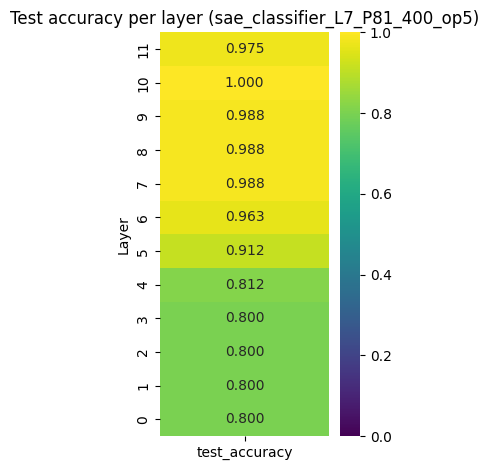

In [3]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path to SAE classifier results
sae_results_path = Path("partition_results_das") / "sae_classifier_L7_P81_400_op5.json"

with open(sae_results_path) as f:
    sae_results = json.load(f)

layers = [entry["layer"] for entry in sae_results["results_per_layer"]]
test_accuracies = [entry["test_accuracy"] for entry in sae_results["results_per_layer"]]

# Reverse order so layer 0 is at the bottom and highest layer at the top
layers_rev = layers[::-1]
heatmap_data = np.array(test_accuracies)[::-1, None]

plt.figure(figsize=(3.0, max(4, len(layers) * 0.4)))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    xticklabels=["test_accuracy"],
    yticklabels=layers_rev,
    vmin=0.0,
    vmax=1.0,
)
plt.ylabel("Layer")
plt.title("Test accuracy per layer (sae_classifier_L7_P81_400_op5)")
plt.tight_layout()
plt.show()